### Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 138 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
class_names

['apple leaf',
 'grape leaf',
 'peach leaf',
 'pepper leaf',
 'potato leaf',
 'tomato leaf']

In [5]:

68*32 ## there are 32 batches

2176

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 5  7  7 10  4 14 11  3 12 10 13 13 10 12 12 11  2  0  5 13 11  7  9 13
 10 14 13  4  3  9 12  2]


tf.Tensor(
[[[102.  91.  95.]
  [101.  90.  94.]
  [101.  90.  94.]
  ...
  [114. 105. 108.]
  [101.  92.  95.]
  [106.  97. 100.]]

 [[ 99.  88.  92.]
  [100.  89.  93.]
  [103.  92.  96.]
  ...
  [112. 103. 106.]
  [107.  98. 101.]
  [109. 100. 103.]]

 [[104.  93.  97.]
  [107.  96. 100.]
  [112. 101. 105.]
  ...
  [112. 103. 106.]
  [118. 109. 112.]
  [116. 107. 110.]]

 ...

 [[174. 168. 170.]
  [154. 148. 150.]
  [171. 165. 167.]
  ...
  [150. 142. 140.]
  [152. 144. 142.]
  [150. 142. 140.]]

 [[166. 160. 162.]
  [142. 136. 138.]
  [149. 143. 145.]
  ...
  [150. 142. 140.]
  [151. 143. 141.]
  [147. 139. 137.]]

 [[165. 159. 161.]
  [179. 173. 175.]
  [146. 140. 142.]
  ...
  [155. 147. 145.]
  [154. 146. 144.]
  [147. 139. 137.]]], shape=(256, 256, 3), dtype=float32)
[[[102.  91.  95.]
  [101.  90.  94.]
  [101.  90.  94.]
  ...
  [114. 105. 108.]
  [101.  92.  95.]
  [106.  97. 100.]]

 [[ 99.  88.  92.]
  [100.  89.  93.]
  [103.  92.  96.]
  ...
  [112. 103. 106.]
  [107.  9

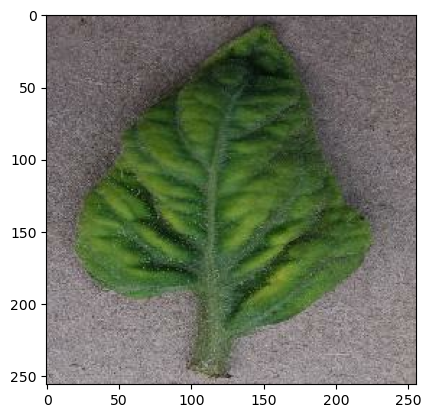

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0])##first image in tensor
    print(image_batch[0].numpy()) ## tensor to numpy
    print(image_batch[0].shape)
    plt.imshow(image_batch[0].numpy().astype("uint8"))## to visualise the first image
    

### Visualize some of the images from our dataset

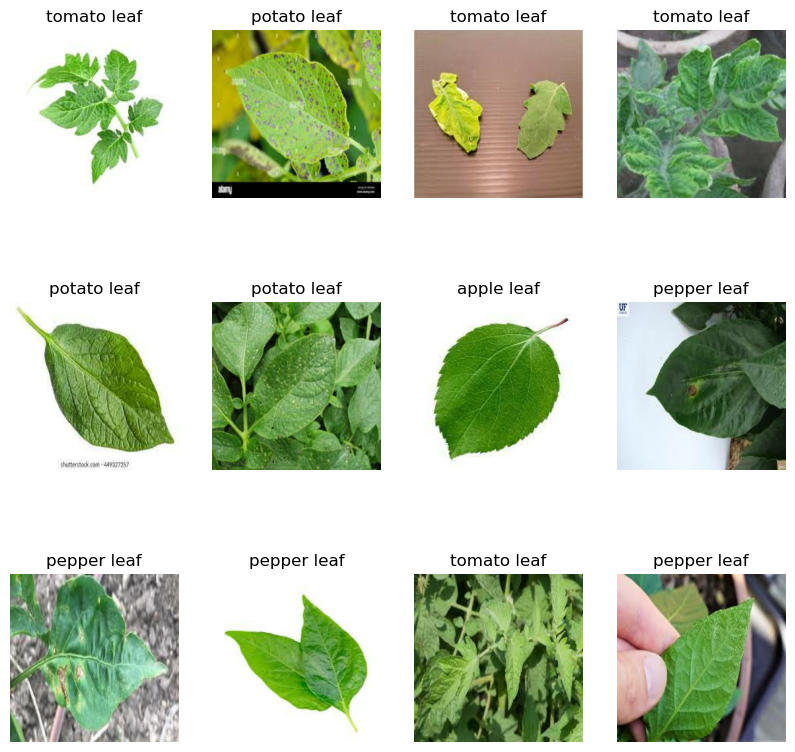

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):## showing the diff images
        ax = plt.subplot(3, 4, i + 1)## the way we are showing the images this func is for it
        plt.imshow(image_batch[i].numpy().astype("uint8"))## imges_bacth is actually using the single batch images 
        plt.title(class_names[labels_batch[i]])## this shows the disease actually by using the class name
        
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [10]:
len(dataset)

874

In [11]:
## 80% traning
##20%= 10%validation(used during training )+10% test(for accuracy of our model)
## after each epoch we do validation on this 10% data


In [12]:
train_size = 0.8
len(dataset)*train_size

699.2

In [13]:
train_ds = dataset.take(54)## first 54
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)##after 54
len(test_ds)

820

In [15]:
val_size=0.1 ## validation size
len(dataset)*val_size

87.4

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

814

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [34]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
len(train_ds)

54

In [36]:
len(val_ds)

6

In [37]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
##this will read the image from the disk and then for the next iteration when you need the same image it will keep that image in the memory.
## this improves the performance of our pipeline again

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)## if gpu is busy then prefatch will load the next batch of our disk that will improves the per formance
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [26]:
## lets say our image is not 256 /256 then this resize and rescale will change it to 256/256
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),## diving it by 255 so that we get the number between 0 and 1
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [41]:
## different types of layers we are  using in our model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
     layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [42]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [59]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 99s 2s/step - loss: 0.8948 - accuracy: 0.4878 - val_loss: 0.8688 - val_accuracy: 0.6510
Epoch 2/50
54/54 [==============================] - 98s 2s/step - loss: 0.7374 - accuracy: 0.6303 - val_loss: 0.7105 - val_accuracy: 0.6771
Epoch 3/50
54/54 [==============================] - 125s 2s/step - loss: 0.6001 - accuracy: 0.7353 - val_loss: 0.6919 - val_accuracy: 0.6667
Epoch 4/50
54/54 [==============================] - 123s 2s/step - loss: 0.4968 - accuracy: 0.7717 - val_loss: 0.7146 - val_accuracy: 0.6094
Epoch 5/50
54/54 [==============================] - 125s 2s/step - loss: 0.4243 - accuracy: 0.8198 - val_loss: 0.3235 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 108s 2s/step - loss: 0.2673 - accuracy: 0.8938 - val_loss: 0.1852 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 93s 2s/step - loss: 0.2276 - accuracy: 0.9155 - val_loss: 0.2635 - val_accuracy: 0.8854
Epoch 8/50
54/54

In [60]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 445ms/step - loss: 2.4068e-05 - accuracy: 1.0000


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [62]:
scores

[2.406847670499701e-05, 1.0]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [68]:
history

In [64]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [65]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [66]:
type(history.history['loss'])

list

In [67]:
len(history.history['loss'])

50

In [69]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8947528004646301,
 0.7373615503311157,
 0.6000609993934631,
 0.4967658519744873,
 0.424297958612442]

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

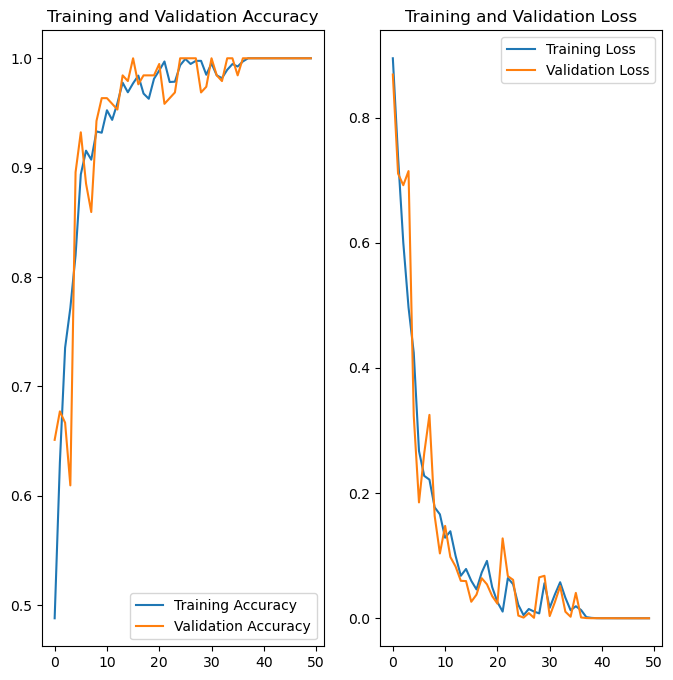

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [7]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

NameError: name 'test_ds' is not defined

### Write a function for inference

In [73]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

### Saving the Model
We append the model to the list of models as a new version

In [75]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

In [48]:
model.save("../potatoes.h5")